In [1]:
import sys
sys.path.append("/media/wdp/disk4/git/noiseba/src")  

import numpy as np
import matplotlib.pyplot as plt

from disba import PhaseDispersion

from noiseba.inversion import Curve, Model, CostFunction, Inversion,   trans_2d_profile
from noiseba.utils import plot_phase_velocity_curves, plot_velocity_profile, load_ccf_index, assign_locations_from_ccf_index
from noiseba.optimization import CDO, LBFGSOptimizer, NelderMeadOptimizer

## Synthetic dispersion curves

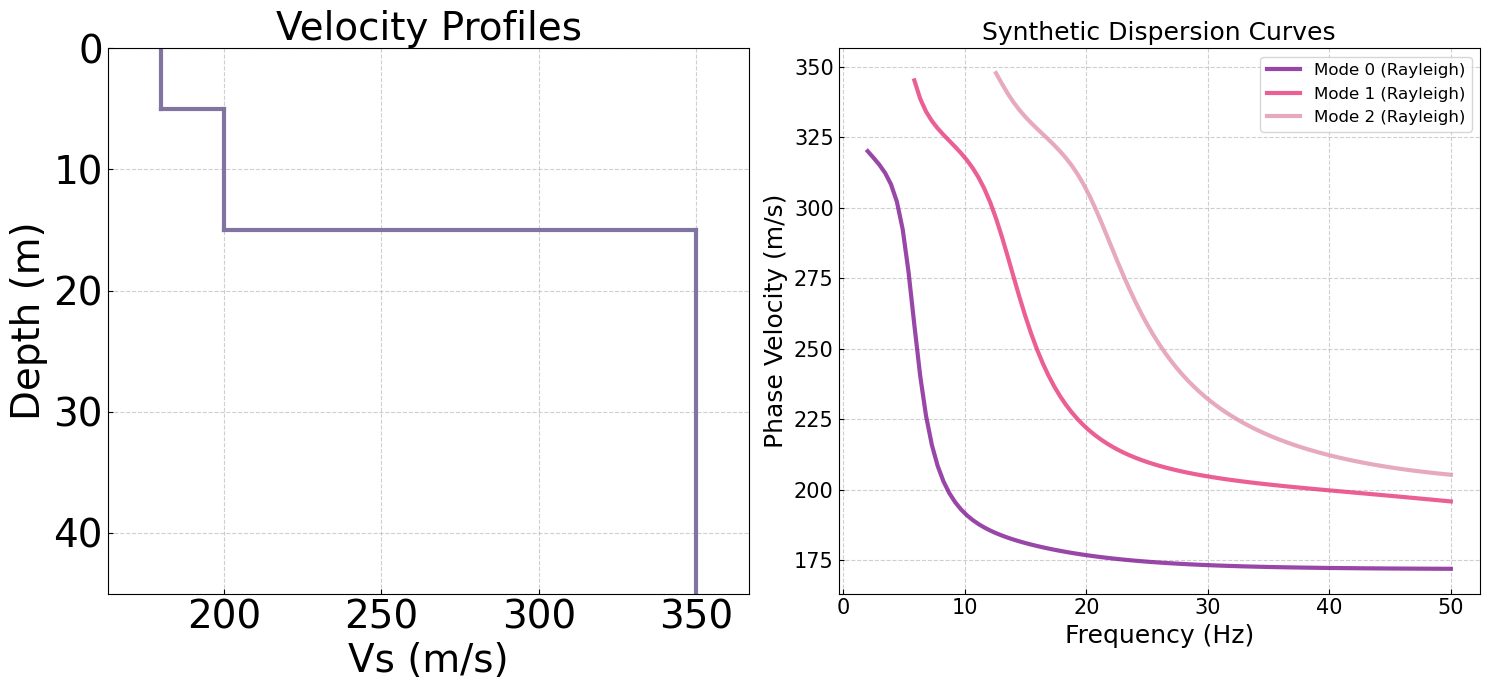

In [2]:
# thickness(km), vp(km/s), vs, rho in sequence
velocity_model = np.array([
   [0.005, 1.50, 0.18, 1.78],
   [0.01,  1.60, 0.20, 1.80],
   [0.05,  1.70, 0.35, 1.85],
])

frequencies = np.linspace(2, 50, 101)
periods = np.flipud(1 / frequencies)  # Sort periods from high to low for disba

# Calculate theoretical dispersion curves for Rayleigh waves
pdv = PhaseDispersion(*velocity_model.T)
cpr = [
    pdv(periods, mode=i, wave="rayleigh") for i in range(3)  # Fundamentals + first 2 higher modes
]

# Plot velocity profile
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
plot_velocity_profile(velocity_model[:, 2], velocity_model[:, 0], axes=axes[0], unit='m')
axes[0].grid(True, linestyle='--', alpha=0.6)

colors = [ '#7E1891', '#E73879', '#E195AB']
for i, item in enumerate(cpr):
    freq = np.flipud(1 / item.period)
    vel = np.flipud(item.velocity) * 1e3
    axes[1].plot(
        freq, vel, 
        color=colors[i], 
        linewidth=3, 
        label=f'Mode {i} (Rayleigh)',
        alpha=0.8
    )

axes[1].set_xlabel('Frequency (Hz)', fontsize=18)
axes[1].set_ylabel('Phase Velocity (m/s)', fontsize=18)
axes[1].set_title('Synthetic Dispersion Curves', fontsize=18)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend(fontsize=12)

axes[1].tick_params(axis='both', direction='in', which='major', labelsize=15)

plt.tight_layout()
plt.show()

## Define survey

In [3]:
ccf_index = load_ccf_index('./ccf_index.csv')
# Store the observed curves
curves = [Curve(freq=np.flipud(1 / cpr[0].period), velocity=np.flipud(cpr[0].velocity), wave_type='rayleigh', mode=0,),
           Curve(freq=np.flipud(1 / cpr[1].period), velocity=np.flipud(cpr[1].velocity), wave_type='rayleigh', mode=1)]

# # Assign the spatial position coordinates of the dispersion curve
# curves = assign_locations_from_ccf_index(curves, ccf_index)

series_curves = {} 
for ind in range(5):
    subset_curves = [Curve(freq=np.flipud(1 / cpr[0].period), velocity=np.flipud(cpr[0].velocity), wave_type='rayleigh', mode=0,),
                    Curve(freq=np.flipud(1 / cpr[1].period), velocity=np.flipud(cpr[1].velocity), wave_type='rayleigh', mode=1)]
    subset_curves = assign_locations_from_ccf_index(subset_curves, ccf_index, target_point=(ind*2*1e-3, 0))
    series_curves[f'site{ind}'] = subset_curves


Loaded CCF index from ./ccf_index.csv (csv), 190 records.


## Define initial model and optimization parameters
- In practice, we only invert the parameters of vs and thickness, as they exhibit greater sensitivity to the dispersion curves.. Hence, vp and density are inferred from the above two parameters

In [4]:
# define cost function
# alpha contral the weight of smoothness term, weights control the weight of each dispersion curves

cost_func_config = {
    "nlayers": 3,
    "mode": "global",
    "alpha_s": 1e-1,
    "alpha_z": 1e-2,
    "alpha_zz": 0,
    "alpha_h": 1,
    "lamb": 1,
    "weights": [1, 1]
}

cost_functions = {}

for key, sub_curves in series_curves.items():
    cost_functions[key] = CostFunction(
        curves=sub_curves,
        **cost_func_config
    )

In [5]:
# bounds [thick_low, thick_high, vs_low, vs_high]
param_bounds = np.array([[0.003, 0.008, 0.15, 0.20],
                        [0.005, 0.025, 0.15, 0.25],
                        [0.02,  0.060,  0.30, 0.40]])


# estimate model parameters
thick = param_bounds[:, 1]
vs = param_bounds[:, 2]
vs = np.log(vs)
thick = np.log(thick)
model = np.r_[thick, vs]
cost_functions['site0'](model)
print(cost_functions['site0'])

             INVERSION COST FUNCTION BREAKDOWN              
------------------------------------------------------------
Component                 | Model Regularization          
------------------------------------------------------------
λ (lambda)                | 1.0000                        
α_s (prior weight)        | 1.0000e-01                    
α_z (smoothness)          | 1.0000e-02                    
α_zz (curvature)          | 0.0000e+00                    
α_h (thickness smooth)    | 1.0000e+00                    
------------------------------------------------------------
Data Misfit               | 140.0609                      
Model Penalty             | 2.9411                        
Chi Factor                | 140.0609                      
Model Norm                | 8.6477                        
Total Misfit              | 143.0019                      


In [6]:
# define initial model
log_bounds = np.log(param_bounds)
model = Model(log_bounds)

# Define optimization parameters
optimizer = CDO
optimization_directives = {
    "population_size": 50,
    "max_iterations": 300,
    "c1": 2.1,              
    "c2": 2.1,              
    "njobs": 16,             # Number of parallel jobs
    "chi_factor": .5,        # Chi factor for convergence
    "model_norm": 1e-4,     # Model norm regularization
    "rng_seed": 42,         # Random seed for reproducibility", magic seed [42, 7, 19, 73, 20, 88]
}

# Create inversion object
inv = Inversion(cost_functions, optimizer, optimization_directives)


print(f"Parameter bounds shape: {param_bounds.shape}")
print(f"Number of parameters to invert: {param_bounds.shape[0] * 2} (thickness + velocity)")
print("Optimization parameters:")
for key, value in optimization_directives.items():
    print(f"  - {key}: {value}")
print()

Parameter bounds shape: (3, 4)
Number of parameters to invert: 6 (thickness + velocity)
Optimization parameters:
  - population_size: 50
  - max_iterations: 300
  - c1: 2.1
  - c2: 2.1
  - njobs: 16
  - chi_factor: 0.5
  - model_norm: 0.0001
  - rng_seed: 42



## Run the inversion

In [7]:
inv.run(model)
print("\nInversion completed!")
print(f"  - Best fitness value: {inv.best_misfit():.6f}")
print(f"  - Number of iterations: {len(inv.chi_factor_history())}")
print(f"  - Final chi factor: {inv.chi_factor_history()[-1]:.6f}")
print()

CDO Optimizing:   1%|          | 2/300 , RMS=5.450972e-01, Model_norm=6.443206e+00
CDO Optimizing:   1%|          | 2/300 , RMS=5.450972e-01, Model_norm=6.443206e+00
CDO Optimizing:   1%|          | 2/300 , RMS=5.450972e-01, Model_norm=6.443206e+00
CDO Optimizing:   1%|          | 2/300 , RMS=5.450972e-01, Model_norm=6.443206e+00
CDO Optimizing:   1%|          | 2/300 , RMS=5.450972e-01, Model_norm=6.443206e+00


Inversion completed!
  - Best fitness value: 2.883188
  - Number of iterations: 300
  - Final chi factor: 0.422302



## Plotting Misfit
Analyze the convergence behavior of the inversion. We'll examine how the
data misfit and model norm evolve with iterations, as well as the total misfit function

- chi factor: 
$$
chifactor = \frac{1}{N}\cdot\sum_{i=1}^{N}(\frac{d_{obs} - d_{pre}}{\sigma} )^2
$$
- model norm: 
$$
modelnorm = \sum_{i=1}^{N}(v_i - v_{ref})^2
$$

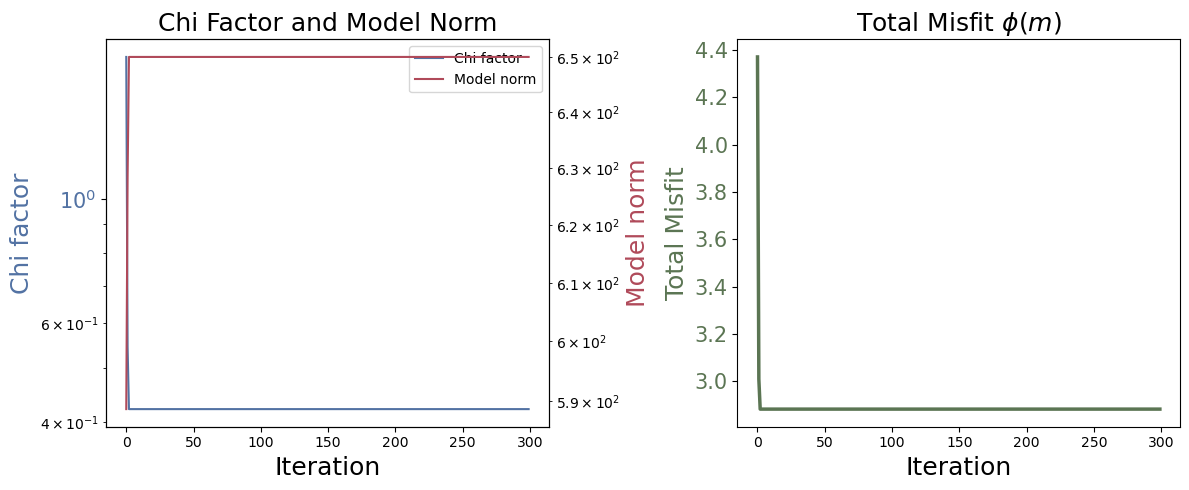

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Left subplot: Chi factor (log scale) and Model norm (exp scale) ---
# Chi factor on left Y-axis
color_chi = "#5272a3"  # deeper blue-gray
ax1.semilogy(inv.chi_factor_history(), color=color_chi, label='Chi factor')
ax1.set_ylabel('Chi factor', color=color_chi, fontsize=18)
ax1.tick_params(axis='y', labelcolor=color_chi, labelsize=15)

# Model norm on right Y-axis
ax1b = ax1.twinx()
color_norm = '#b04a5a'  # deeper rose red
ax1b.semilogy(np.exp(inv.model_norm_history()), color=color_norm, label='Model norm')
ax1b.set_ylabel('Model norm', color=color_norm, fontsize=18)
ax1b.tick_params(axis='y', labelcolor=color_norm, labelsize=15)
ax1.set_xlabel('Iteration', fontsize=18)

# Merge legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Title for subplot
ax1.set_title('Chi Factor and Model Norm', fontsize=18)


# --- Right subplot: Total misfit history ---
misfit_color= '#5b7553'  # deeper olive green
total_misfit = inv.total_misfit_history()
ax2.plot(total_misfit, color=misfit_color, linewidth=2.5)
ax2.set_xlabel('Iteration', fontsize=18)
ax2.set_ylabel('Total Misfit', fontsize=18, color=misfit_color)
ax2.tick_params(axis='y', labelcolor=misfit_color, labelsize=15)
ax2.set_title(r'Total Misfit $\phi(m)$', fontsize=18)
# ax2.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## Compare the synthetic data with the inversion results

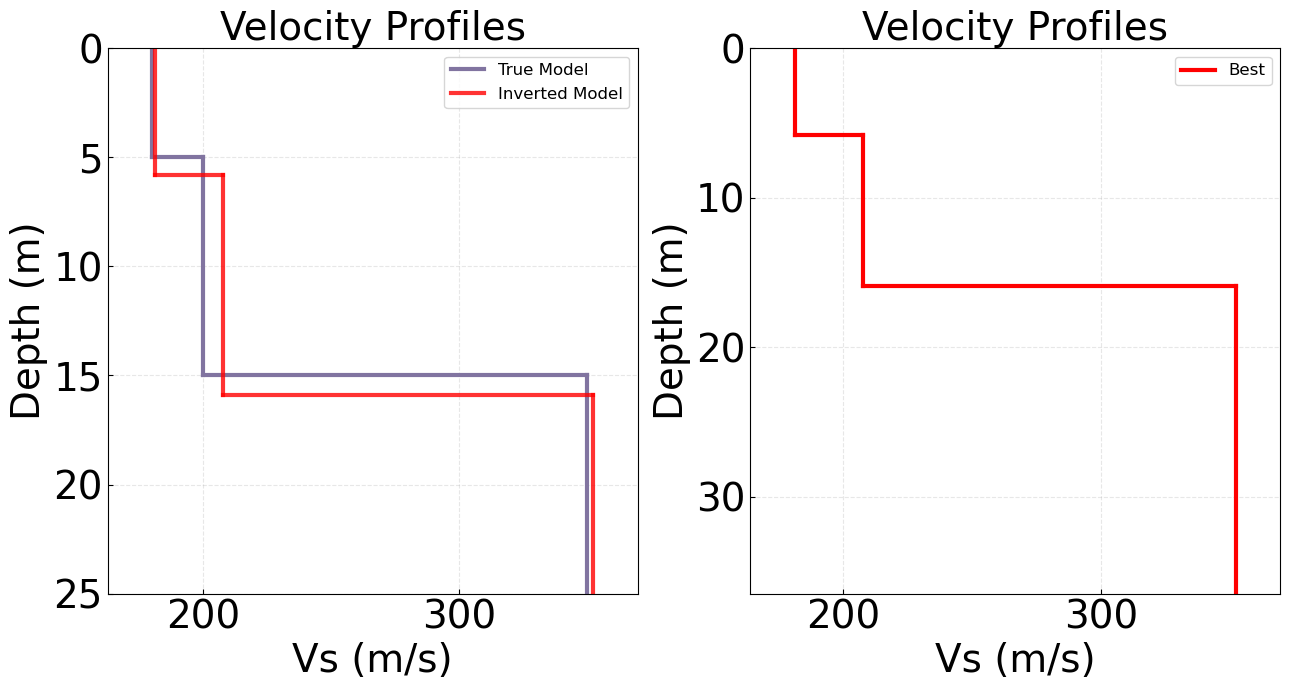

In [9]:
# True model
true_vs = velocity_model[:, 2]
true_thickness = velocity_model[:, 0]

# Inverted model
n_layers = log_bounds.shape[0]
inv_params = inv.best_position(site="site1")
inverted_thickness = np.exp(inv_params[:n_layers])
inverted_vs = np.exp(inv_params[n_layers:])

# Filtered history model
history_positions = inv.history_positions(threshold=0.5)
history_vs = np.exp(history_positions[:, n_layers:][::30])   # type: ignore 
history_thickness = np.exp(history_positions[:, :n_layers][::30]) # type: ignore


fig, ax = plt.subplots(1, 2, figsize=(13, 7))

plot_velocity_profile(true_vs, true_thickness, unit='m', axes=ax[0], plot_kwargs={'label': 'True Model'})
plot_velocity_profile(inverted_vs, inverted_thickness, unit='m', axes=ax[0], plot_kwargs={'color': 'r', 'label': 'Inverted Model', 'alpha': 0.8})
ax[0].legend(fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.3)
ax[0].set_ylim(bottom=25)

# Plot history model
plot_velocity_profile(history_vs,  history_thickness, unit='m', axes=ax[1], plot_kwargs={'color': 'gray', 'alpha': 0.3})
plot_velocity_profile(inverted_vs, inverted_thickness, unit='m', axes=ax[1], plot_kwargs={'color': 'r', 'label': 'Best'})

ax[1].legend(fontsize=12)  
ax[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
# fig.savefig('vs_normalvs1.png', dpi=300, bbox_inches='tight')

<Axes: title={'center': '2D Shear-Wave Velocity Profile'}, xlabel='Distance (km)', ylabel='Depth (km)'>

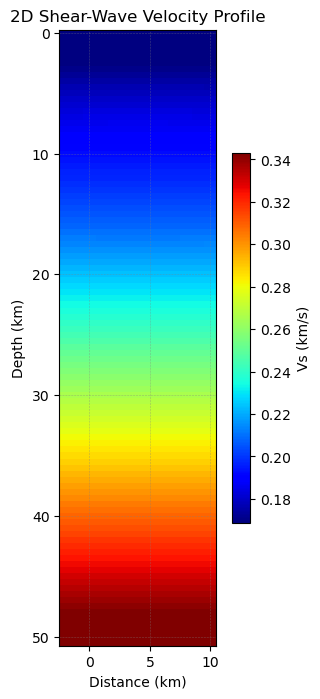

In [10]:
inversion_results = {site: inv for site in series_curves.keys()}

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

trans_2d_profile(
    inversion_results,
    x_coords=None,
    unit="m",
    grid_spacing_x=1.0,
    grid_spacing_z=0.5,
    depth_range=None,
    x_padding=2.0,
    z_extra_bottom=0.0,
    tension=0.35,
    gaussian_sigma=None,
    vs_range=None,
    ax=ax,
    add_colorbar=True,
    cmap="jet",
)


## Plotting True and Inverted Dispersion Curves

In [11]:
filtered_curves = inv.history_curves(threshold=1) # threshold/ no more smaller than total misfit

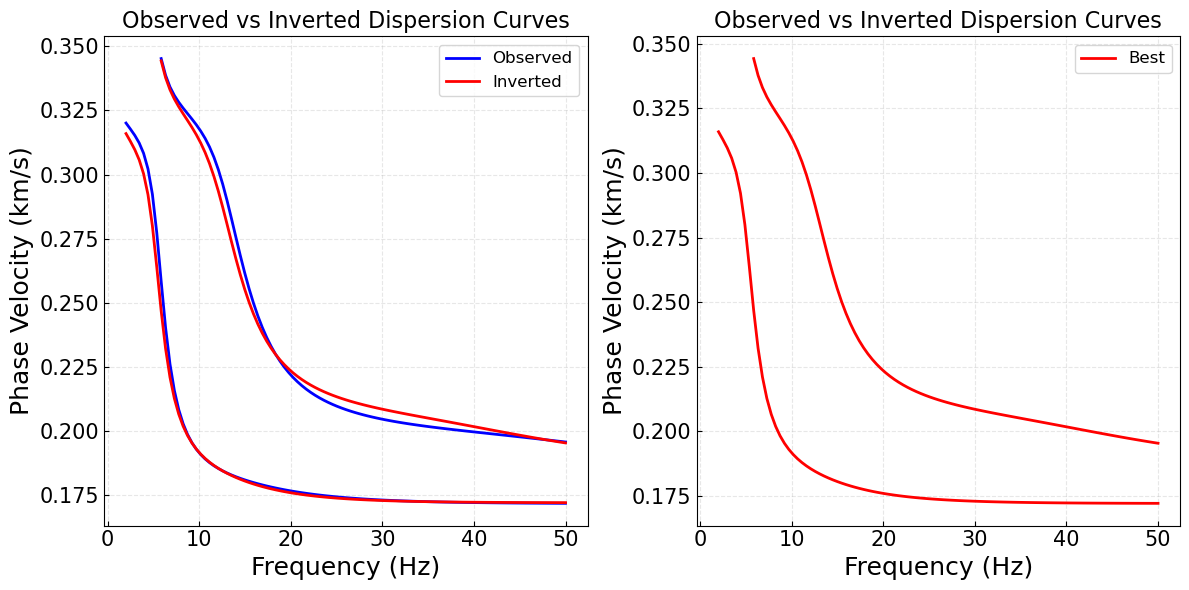

In [12]:
# Inversion results
inv_curves_m0 = inv.best_curves().get('rmode0')
inv_curves_m1 = inv.best_curves().get('rmode1')

# Get observed (synthetic) curves
observed_curves_data = inv.result['site0']['obs_curves']

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
obs_m0, obs_m1 = observed_curves_data
# obs_m0 = observed_curves_data[0]

plot_phase_velocity_curves(obs_m0.freq, obs_m0.velocity, axes=ax[0], plot_kwargs={'color': 'b', 'label': 'Observed', 'lw': 2})
plot_phase_velocity_curves(obs_m1.freq, obs_m1.velocity, axes=ax[0], plot_kwargs={'color': 'b', 'lw': 2})

plot_phase_velocity_curves(inv_curves_m0[0].freq, inv_curves_m0[0].velocity, axes=ax[0], plot_kwargs={'color': 'r', 'label': 'Inverted', 'lw': 2})
plot_phase_velocity_curves(inv_curves_m1[0].freq, inv_curves_m1[0].velocity, axes=ax[0], plot_kwargs={'color': 'r', 'lw': 2})

ax[0].set_xlabel('Frequency (Hz)', fontsize=18)
ax[0].set_ylabel('Phase Velocity (km/s)', fontsize=18)
ax[0].set_title('Observed vs Inverted Dispersion Curves', fontsize=16)
ax[0].legend(fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.3)
ax[0].tick_params(axis='both', direction='in', which='major', labelsize=15)

# plot evolution of dispersion curves
for key in filtered_curves.keys():
    for cur in filtered_curves[key][::30]:
        freq = cur.freq
        vel = cur.velocity
        plot_phase_velocity_curves(freq, vel, axes=ax[1], plot_kwargs={'color': 'k', 'alpha':0.8})


plot_phase_velocity_curves(inv_curves_m0[0].freq, inv_curves_m0[0].velocity, axes=ax[1], plot_kwargs={'color': 'r', 'lw': 2, 'label': 'Best'})
plot_phase_velocity_curves(inv_curves_m1[0].freq, inv_curves_m1[0].velocity, axes=ax[1], plot_kwargs={'color': 'r', 'lw': 2})

ax[1].set_xlabel('Frequency (Hz)', fontsize=18)
ax[1].set_ylabel('Phase Velocity (km/s)', fontsize=18)
ax[1].set_title('Observed vs Inverted Dispersion Curves', fontsize=16)
ax[1].legend(fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.3)
ax[1].tick_params(axis='both', direction='in', which='major', labelsize=15)

plt.tight_layout()
# fig.savefig('inversion_curves_vsnormal1.png', dpi=300, bbox_inches='tight')
